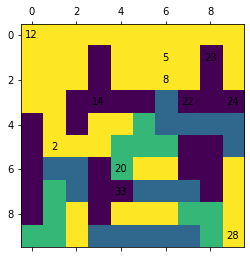

In [402]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt


m, b, g, y = 0, 1, 2, 3
grid = np.array([
    [y, y, y, y, y, y, y, y, y, y], 
    [y, y, y, m, y, y, y, y, m, y], 
    [y, y, y, m, y, y, y, y, m, y], 
    [y, y, m, m, m, m, b, m, m, m], 
    [m, y, m, y, y, g, b, b, b, b], 
    [m, y, y, y, g, g, g, m, m, b], 
    [m, b, b, m, g, y, y, m, m, y], 
    [m, g, b, m, m, b, b, b, m, y], 
    [m, g, y, m, y, y, y, g, g, y], 
    [g, g, y, b, b, b, b, b, g, y]
]) 
m1, m2, m3, m4, m5 = 0.1, 0.2, 0.3, 0.4, 0.5
b1, b2, b3, b4 = 1.1, 1.2, 1.3, 1.4
g1, g2, g3 = 2.1, 2.2, 2.3
y1, y2, y3, y4, y5 = 3.1, 3.2, 3.3, 3.4, 3.5
rcodes = [m1, m2, m3, m4, m5, b1, b2, b3, b4, g1, g2, g3, y1, y2, y3, y4, y5]
regions = np.array([
    [y1, y1, y1, y1, y1, y1, y1, y1, y1, y1], 
    [y1, y1, y1, m1, y1, y1, y1, y1, m2, y1], 
    [y1, y1, y1, m1, y1, y1, y1, y1, m2, y1], 
    [y1, y1, m1, m1, m1, m1, b1, m2, m2, m2], 
    [m3, y1, m1, y1, y1, g1, b1, b1, b1, b1], 
    [m3, y1, y1, y1, g1, g1, g1, m4, m4, b1], 
    [m3, b2, b2, m5, g1, y2, y2, m4, m4, y5], 
    [m3, g2, b2, m5, m5, b3, b3, b3, m4, y5], 
    [m3, g2, y3, m5, y4, y4, y4, g3, g3, y5], 
    [g2, g2, y3, b4, b4, b4, b4, b4, g3, y5]
]) 

pos = {2:(5,1), 5:(1,6), 8:(2,6), 12:(0,0), 14:(3,3), 20:(6,4), 22:(3,7), 23:(1,8), 24:(3,9), 28:(9,9), 33:(7,4)}

def display(g, p):
    plt.matshow(g)
    botax = plt.gca()
    for k in p.keys():
        i, j = p[k]
        botax.text(j, i, str(k), ha="center", va="center");
    
display(grid, pos)


In [272]:
def nhood(sq):
    i, j = sq
    resp = np.zeros((10,10));
    resp[i-2:i+4:4, j-1:j+3:2] = resp[i-1:i+3:2, j-2:j+4:4] = 1;
    if(i+2<10):resp[i+2, j-1:j+3:2] = 1
    if(j+2<10):resp[i-1:i+3:2, j+2] = 1
    if(j+1<10):resp[i-2:i+4:4, j+1] = 1
    if(i+1<10):resp[i+1, j-2:j+4:4] = 1
    if(i+2 < 10 and j+1 < 10): resp[i+2,j+1] = 1
    if(i+1 < 10 and j+2 < 10): resp[i+1,j+2] = 1
    return resp


def nhoodgen(sq, hops):
    if hops == 0:
        i,j = sq
        resp = np.zeros((10,10))
        resp[i,j] = 1
        return resp
    elif hops == 1:
        return nhood(sq)
    else:
        resp = np.zeros((10,10));
        tuparr = np.where(nhoodgen(sq, hops-1)==1)
        for sq in list(zip(tuparr[0], tuparr[1])):
            resp = 1 - (1 - resp)*(1 - nhood(sq))
    
    return resp

In [1222]:
def region_sum(regcode, positions):
    return sum(label for label in positions if regions[positions[label][0], positions[label][1]] == regcode)

def checksum(posr):
    sums = set([region_sum(regcode, posr) for regcode in rcodes])
    sums.discard(0)
    return len(sums) == 1
    
    
def get_position_from_label(curr_label, curr_pos, pos, posr, exclusion_zone):
    # Dada a label atual, procuramos uma posição possível
    # Procura predecessor e sucessor:
    preds = [k for k in pos.keys() if k <= curr_label]
    pred_label = max(preds) if len(preds) > 0 else None
    succs = [k for k in pos.keys() if k >= curr_label]
    succ_label = min(succs) if len(succs) > 0 else None

    pred_reach = nhoodgen(pos[pred_label], curr_label - pred_label) if pred_label else np.ones((10,10))
    succ_reach = nhoodgen(pos[succ_label], succ_label - curr_label) if succ_label else np.ones((10,10))

    # Buscamos agora as casas acessíveis pela posição anterior da random walk
    curr_reach = nhood(curr_pos) if curr_pos else np.ones((10,10))

    # Construímos o mapa das possíveis posições
    possibilities = pred_reach * curr_reach * succ_reach * exclusion_zone

    # Em seguida, temos que descontar as casas que já foram visitadas pela RW ou cuja posição já é conhecida
    for label in posr:
        if label != curr_label:
            i, j = posr[label]
            possibilities[i,j] = 0

    # Por fim, excluímos as posições que fazem a soma de alguma região ultrapassar 75
    S = 75
    for rcode in rcodes:
        if region_sum(rcode, posr) + curr_label > S and curr_label not in pos:
            possibilities *= (regions != rcode)
            
    # Agora finalmente, sorteamos uma posição válida dentro das possibilidades. 
    tuparr = np.where(possibilities == 1)
    pos_list = list(zip(tuparr[0], tuparr[1]))

    # Atenção: e se pos_list for vazia? A RW falha e retorna o resultado obtido. 
    if len(pos_list) == 0:
        return (True, posr)

    # Se não houver pane, amostramos uma posição possível e a adicionamos na lista. 
    curr_pos = pos_list[npr.choice(range(len(pos_list)))]
    posr[curr_label] = curr_pos
    return (False, posr)




    
def random_walk(pos, exclusion_zone=np.ones((10,10)), verbose=False):
    # pos é o dict com as posições já conhecidas
    posr = {k:pos[k] for k in pos.keys()}
    # posr é o dict que inclui todas as posições já acessadas pela RW além das posições conhecidas
    
    # A cada salto, é definida a label, e procura-se (se possível) uma posição. 
    # Se em algum momento a RW ficar sem casas possíveis, parar e retornar o caminho produzido. 
    # Assumindo que todas as regiões devem ter a mesma soma (i.e., o cavalo deve passar em todas),
    # a soma deve ser 75 e a última label deve ser 50. 
    
    curr_pos = None
    for curr_label in range(1, 51):
        # TODO: Incluir restrição de soma <= 75 a cada passo
        pane, posr = get_position_from_label(curr_label, curr_pos, pos, posr, exclusion_zone)
        if not pane:
            curr_pos = posr[curr_label]
        else:
            if verbose:
                print("Pane!! A Random Walk não consegue prosseguir!")
                print("Último salto: ", curr_label-1)
                print("Situação das somas:")
                print("Yellow: ", [region_sum(rcode, posr) for rcode in [y1, y2, y3, y4, y5]])
                print("Pink: ", [region_sum(rcode, posr) for rcode in [m1, m2, m3, m4, m5]])
                print("Blue: ", [region_sum(rcode, posr) for rcode in [b1, b2, b3, b4]])
                print("Green: ", [region_sum(rcode, posr) for rcode in [g1, g2, g3]])
                display(grid, posr)
            return "fail"
    
    print("Passeio completado com sucesso!!!! YAAAAY")
    print("Situação das somas:")
    print("Yellow: ", [region_sum(rcode, posr) for rcode in [y1, y2, y3, y4, y5]])
    print("Pink: ", [region_sum(rcode, posr) for rcode in [m1, m2, m3, m4, m5]])
    print("Blue: ", [region_sum(rcode, posr) for rcode in [b1, b2, b3, b4]])
    print("Green: ", [region_sum(rcode, posr) for rcode in [g1, g2, g3]])
    display(grid, posr)
    return "sucess"
    
    
def quasipersistent_RW(pos, exclusion_zone=np.ones((10,10))):
    status = random_walk(pos, exclusion_zone, verbose = False)
    while status == "fail":
        status = random_walk(pos, exclusion_zone, verbose = False)
    

In [1540]:
pos2 = {k:pos[k] for k in pos.keys()}
pos2[6] = (2,8)
pos2[15] = (5,4)
pos2[19] = (5,6)
pos2[21] = (4,5)
pos2[47] = (6,9)

exclusion_zone = np.array([
    [1,0,1,0,0,1,0,1,0,0], 
    [0,0,1,1,1,0,1,0,1,0], 
    [0,1,0,1,1,1,1,1,1,0], 
    [1,0,1,1,1,1,1,1,0,1], 
    [1,1,1,1,0,1,1,1,1,1], 
    [1,1,1,0,1,0,1,1,1,1], 
    [1,1,1,1,1,1,1,1,1,1], 
    [1,1,1,1,1,1,1,1,1,0], 
    [1,1,1,1,1,1,1,1,1,0], 
    [1,1,1,1,1,1,1,1,0,1]
])



#random_walk(pos2, exclusion_zone, verbose=True);
#quasipersistent_RW(pos2, exclusion_zone)



search(pos2, exclusion_zone)

17 (4, 7)
18 (6, 8)
19 (5, 6)
20 (6, 4)
21 (4, 5)
22 (3, 7)
23 (1, 8)
24 (3, 9)
25 (5, 8)
26 (6, 6)
27 (7, 8)
28 (9, 9)
29 (8, 7)
30 (7, 5)
31 (6, 3)
32 (8, 2)
33 (7, 4)
34 (6, 2)
35 (5, 0)
36 (7, 1)
37 (9, 0)
39 (7, 2)
40 (8, 4)
41 (6, 3)
37 (7, 2)
38 (6, 0)
39 (8, 1)
40 (7, 3)
41 (9, 2)
42 (9, 5)
40 (8, 0)
41 (6, 5)
42 (4, 6)
40 (8, 4)
41 (6, 5)
42 (4, 6)
43 (5, 8)
44 (7, 7)
44 (6, 8)
45 (4, 9)
40 (8, 8)
41 (7, 6)
40 (9, 5)
41 (7, 6)
42 (8, 4)
43 (6, 5)
40 (9, 3)
41 (8, 1)
41 (9, 6)
42 (8, 8)
39 (7, 0)
40 (6, 2)
40 (9, 3)
41 (7, 2)
39 (7, 0)
37 (8, 5)
38 (6, 6)
40 (7, 3)
41 (6, 5)
42 (8, 4)
43 (9, 6)
44 (8, 8)
38 (8, 4)
39 (6, 5)
41 (6, 5)
42 (7, 3)
38 (8, 0)
39 (9, 2)
40 (7, 1)
42 (9, 5)
42 (8, 8)
39 (9, 2)
40 (7, 1)
40 (8, 4)
41 (6, 5)
43 (9, 6)
44 (7, 5)
42 (7, 5)
40 (9, 5)
41 (7, 6)
42 (5, 7)
41 (9, 0)
40 (6, 2)
41 (8, 3)
39 (8, 3)
40 (6, 2)
41 (5, 0)
42 (4, 2)
41 (7, 0)
41 (9, 6)
42 (8, 8)
41 (8, 5)
37 (9, 0)
38 (7, 1)
39 (5, 0)
40 (4, 2)
41 (6, 1)
42 (7, 3)
43 (8, 5)
40 (6, 8)


38 (9, 5)
39 (7, 6)
40 (8, 4)
41 (6, 5)
42 (9, 5)
41 (7, 6)
42 (8, 8)
44 (9, 5)
44 (8, 6)
41 (8, 5)
40 (6, 2)
42 (7, 3)
43 (8, 1)
37 (8, 3)
38 (6, 2)
39 (5, 0)
40 (4, 2)
38 (8, 4)
39 (6, 5)
40 (4, 6)
41 (3, 4)
40 (8, 8)
41 (7, 6)
40 (9, 7)
41 (7, 6)
42 (8, 8)
40 (8, 0)
42 (9, 7)
42 (7, 7)
39 (9, 2)
40 (7, 1)
41 (5, 0)
41 (9, 6)
42 (8, 8)
40 (8, 8)
40 (9, 3)
40 (9, 1)
41 (7, 0)
38 (6, 2)
39 (5, 0)
40 (4, 2)
39 (9, 6)
40 (7, 7)
41 (6, 5)
41 (9, 2)
38 (7, 3)
39 (6, 1)
40 (4, 0)
40 (8, 4)
41 (6, 5)
42 (7, 7)
41 (7, 2)
42 (9, 3)
38 (8, 4)
39 (6, 5)
40 (7, 7)
38 (8, 0)
39 (9, 2)
40 (7, 1)
40 (8, 0)
41 (9, 2)
42 (9, 3)
43 (8, 5)
44 (7, 7)
45 (6, 5)
38 (7, 1)
39 (6, 3)
40 (4, 2)
38 (8, 6)
40 (8, 0)
41 (9, 2)
42 (8, 4)
43 (6, 5)
44 (4, 6)
42 (8, 8)
43 (7, 6)
43 (7, 6)
44 (8, 8)
42 (8, 8)
43 (7, 6)
44 (8, 8)
45 (7, 6)
42 (7, 7)
36 (7, 7)
37 (6, 5)
38 (4, 6)
42 (7, 7)
43 (8, 5)
36 (9, 7)
37 (8, 5)
39 (7, 2)
40 (6, 0)
34 (9, 3)
35 (7, 2)
36 (6, 0)
37 (8, 1)
38 (6, 2)
39 (5, 0)
39 (7, 2)
40 (6, 0)


(True,
 {2: (5, 1),
  5: (1, 6),
  8: (2, 6),
  12: (0, 0),
  14: (3, 3),
  20: (6, 4),
  22: (3, 7),
  23: (1, 8),
  24: (3, 9),
  28: (9, 9),
  33: (7, 4),
  6: (2, 8),
  15: (5, 4),
  19: (5, 6),
  21: (4, 5),
  47: (6, 9),
  1: (3, 0),
  3: (4, 3),
  4: (2, 4),
  7: (0, 7),
  9: (0, 5),
  10: (1, 3),
  11: (2, 1),
  13: (1, 2),
  16: (4, 2),
  17: (2, 3),
  18: (3, 5),
  25: (4, 7),
  26: (6, 6),
  27: (7, 8),
  29: (8, 7),
  30: (7, 5),
  31: (9, 4),
  32: (8, 6),
  34: (6, 2),
  35: (7, 0),
  36: (8, 2),
  37: (9, 0),
  38: (7, 1),
  39: (9, 2),
  40: (8, 0),
  41: (6, 1),
  42: (7, 3),
  43: (8, 5),
  44: (9, 7),
  45: (7, 6),
  46: (8, 8),
  48: (5, 7),
  49: (6, 5),
  50: (4, 6)},
 1100)

In [1539]:
def generate_position_list(curr_label, curr_pos, pos, posr, exclusion_zone):
    # Dada a label atual, procuramos uma posição possível
    # Procura predecessor e sucessor:
    preds = [k for k in pos.keys() if k <= curr_label]
    pred_label = max(preds) if len(preds) > 0 else None
    succs = [k for k in pos.keys() if k >= curr_label]
    succ_label = min(succs) if len(succs) > 0 else None

    pred_reach = nhoodgen(pos[pred_label], curr_label - pred_label) if pred_label else np.ones((10,10))
    succ_reach = nhoodgen(pos[succ_label], succ_label - curr_label) if succ_label else np.ones((10,10))

    # Buscamos agora as casas acessíveis pela posição anterior da random walk
    curr_reach = nhood(curr_pos) if curr_pos else np.ones((10,10))

    # Construímos o mapa das possíveis posições
    possibilities = pred_reach * curr_reach * succ_reach * exclusion_zone

    # Em seguida, temos que descontar as casas que já foram visitadas pela RW ou cuja posição já é conhecida
    for label in posr:
        if label != curr_label:
            i, j = posr[label]
            possibilities[i,j] = 0

    # Por fim, excluímos as posições que fazem a soma de alguma região ultrapassar 75
    S = 75
    for rcode in rcodes:
        if region_sum(rcode, posr) + curr_label > S and curr_label not in pos:
            possibilities *= (regions != rcode)
            
    # Agora finalmente, sorteamos uma posição válida dentro das possibilidades. 
    tuparr = np.where(possibilities == 1)
    pos_list = list(zip(tuparr[0], tuparr[1]))

    return pos_list


def dfs(curr_label, curr_pos, pos, posr, exclusion_zone, att):
    success = (curr_label > 50)
    
    if att % 1000 == 1: 
        att %= 1000
        print(curr_label-1, curr_pos)
    
    if not success:
        posd = {k:posr[k] for k in posr.keys()}
        for possibility in generate_position_list(curr_label, curr_pos, pos, posr, exclusion_zone):
            posd[curr_label] = curr_pos = possibility
            status, result, att = dfs(curr_label+1, curr_pos, pos, posd, exclusion_zone, att)
            success |= status
            if success:
                return success, result, att
            else:
                att += 1
    
    return success, posr, att


def search(pos, exclusion_zone):
    posr = {k:pos[k] for k in pos.keys()}
    status, result, att = dfs(1, None, pos, posr, exclusion_zone, 0)
    
    return status, result, att
    

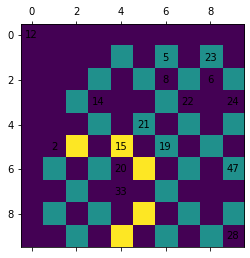

In [1489]:
pos2[19] = (5,6)

grid2 = np.zeros((10,10))
#grid2[nhoodgen(pos2[15], 1)==1] = 1
#grid2[3,3] = grid2[6,6] = 0
#grid2[6,2] = grid2[7,3] = grid2[4,2] = grid2[3,5] = grid2[7,5] = 0

grid2[nhoodgen((7,3), 1)==1] = 1
grid2[nhoodgen(pos2[19], 2)==1] += 1

display(grid2, pos2)


Yellow:  [75, 75, 75, 75, 75]
Pink:  [75, 75, 75, 75, 75]
Blue:  [75, 75, 75, 75]
Green:  [75, 75, 75]


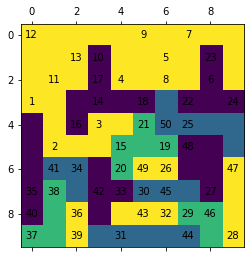

In [1544]:
seramesmovei = {2: (5, 1),
  5: (1, 6),
  8: (2, 6),
  12: (0, 0),
  14: (3, 3),
  20: (6, 4),
  22: (3, 7),
  23: (1, 8),
  24: (3, 9),
  28: (9, 9),
  33: (7, 4),
  6: (2, 8),
  15: (5, 4),
  19: (5, 6),
  21: (4, 5),
  47: (6, 9),
  1: (3, 0),
  3: (4, 3),
  4: (2, 4),
  7: (0, 7),
  9: (0, 5),
  10: (1, 3),
  11: (2, 1),
  13: (1, 2),
  16: (4, 2),
  17: (2, 3),
  18: (3, 5),
  25: (4, 7),
  26: (6, 6),
  27: (7, 8),
  29: (8, 7),
  30: (7, 5),
  31: (9, 4),
  32: (8, 6),
  34: (6, 2),
  35: (7, 0),
  36: (8, 2),
  37: (9, 0),
  38: (7, 1),
  39: (9, 2),
  40: (8, 0),
  41: (6, 1),
  42: (7, 3),
  43: (8, 5),
  44: (9, 7),
  45: (7, 6),
  46: (8, 8),
  48: (5, 7),
  49: (6, 5),
  50: (4, 6)}

print("Yellow: ", [region_sum(rcode, seramesmovei) for rcode in [y1, y2, y3, y4, y5]])
print("Pink: ", [region_sum(rcode, seramesmovei) for rcode in [m1, m2, m3, m4, m5]])
print("Blue: ", [region_sum(rcode, seramesmovei) for rcode in [b1, b2, b3, b4]])
print("Green: ", [region_sum(rcode, seramesmovei) for rcode in [g1, g2, g3]])

display(grid, seramesmovei)

In [1545]:
sqr = lambda x: x**2
sum(sqr(x) for x in [12, 23, 17, 24, 50, 48, 49, 45, 46, 44])

14820